In [1]:
import numpy as np
import scipy as sc
import time
from utils import *
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable
import json

In [9]:
# パラメータを取得
config = load_config('/home/mitsukism/qiskit_entropy/vn_ent_qubits10_training_config.json')

qubits = config["qubits"]
num_wires = config["num_wires"]
num_layers = config["num_layers"]
N = config["N"]
seed = config["seed"]
num_shots = config["num_shots"]
num_of_epochs = config["num_of_epochs"]
learning_rate = 0.01
num_of_samples = config["num_of_samples"]
dimension = config["dimension"]
hidden_layer = config["hidden_layer"]

device = qml.device("default.qubit", wires=num_wires, shots=num_shots)
@qml.qnode(device)
def measure_rho(param, circuit_structure, qubits, rotations=[qml.RX, qml.RY, qml.RZ]):
    obj_wires = range(qubits)   

    qml.Hadamard(wires=0)

    for gate_info in circuit_structure:
        gate = gate_info["gate"]
        wires = gate_info["wires"]
        if gate == "CNOT":
            qml.CNOT(wires=wires)
        elif gate == "PauliX":
            qml.PauliX(wires=wires[0])
        elif gate == "PauliY":
            qml.PauliY(wires=wires[0])
        elif gate == "PauliZ":
            qml.PauliZ(wires=wires[0])

    qml.RandomLayers(param, wires=obj_wires, rotations=rotations)

    result = [qml.sample(qml.PauliZ(i)) for i in range(len(obj_wires))]
    return result

class neural_function(nn.Module):
    def __init__(self,dimension,hidden_layer):
        super(neural_function, self).__init__()

        self.dimension = dimension
        self.hidden_layer = hidden_layer
        self.lin1 = nn.Linear(self.dimension, self.hidden_layer)
        self.lin_end = nn.Linear(self.hidden_layer, 1)

    def forward(self, input):
        y = torch.sigmoid(self.lin1(input.float()))
        y = self.lin_end(y)

        return y

In [10]:
num_of_samples = 1000
# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
# intialize the cost function store
cost_func_store = []
circuit_structure = load_circuit_structure_from_json('/home/mitsukism/qiskit_entropy/circuit_structure.json')
seed = 5

### Gradient計算

In [12]:
num_trial = 10000

circuit_structure = load_circuit_structure_from_json('/home/mitsukism/qiskit_entropy/circuit_structure.json')
neural_fn = neural_function(dimension, hidden_layer)

for n_layer in [5, 7, 9, 11, 13, 15]:
    gradients_all_trials = np.zeros((num_trial, n_layer, 3))
    for idx in range(num_trial):
        start = time.time()
        param = np.random.random(qml.RandomLayers.shape(n_layers=n_layer, n_rotations=3))
        gradients = np.zeros(param.shape)
    
        for i in range(len(gradients)):
            for j in range(len(gradients[0])):
    
          # copy the parameters
                shifted = param.copy()
    
          # right shift the parameters
                shifted[i, j] += np.pi/2
    
          # forward evaluation
                result = measure_rho(shifted, circuit_structure, qubits)
                sample_result_array = np.array(result).T
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                forward_sum = nn_result[:, 0].detach().numpy().sum() / num_of_samples
    
          # left shift the parameters
                shifted[i, j] -= np.pi
    
          # backward evaluation
                backward_sum = 0
                result = measure_rho(shifted, circuit_structure, qubits)
                sample_result_array = np.array(result).T
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                backward_sum = nn_result[:, 0].detach().numpy().sum() / num_of_samples
    
          # parameter-shift rule
                gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

        gradients_all_trials[idx] = gradients
        end = time.time()
        # save_file_path = f'/home/mitsukism/qiskit_entropy/vn_net_gradients_bp/qubits10/gradients_qubits{qubits}_idx{idx}_layer{n_layer}.npy'
        # np.save(save_file_path, gradients)
        print(f'complete time: {end - start}, trial: {idx}, qubits: {qubits}, layers: {n_layer}')
    save_file_path = f'/home/mitsukism/qiskit_entropy/vn_net_gradients_bp/gradients/gradients_qubits{qubits}_layer{n_layer}.npy'
    np.save(save_file_path, gradients_all_trials)
    print("complete collecting samples of gradients, save data to ", save_file_path)

complete time: 0.5678391456604004, trial: 0, save: /home/mitsukism/qiskit_entropy/vn_net_gradients_bp/qubits10/gradients_qubits10_idx0_layer5.npy
complete time: 0.4598863124847412, trial: 1, save: /home/mitsukism/qiskit_entropy/vn_net_gradients_bp/qubits10/gradients_qubits10_idx1_layer5.npy
complete time: 0.46053314208984375, trial: 2, save: /home/mitsukism/qiskit_entropy/vn_net_gradients_bp/qubits10/gradients_qubits10_idx2_layer5.npy
complete time: 0.4596874713897705, trial: 3, save: /home/mitsukism/qiskit_entropy/vn_net_gradients_bp/qubits10/gradients_qubits10_idx3_layer5.npy
complete time: 0.4605906009674072, trial: 4, save: /home/mitsukism/qiskit_entropy/vn_net_gradients_bp/qubits10/gradients_qubits10_idx4_layer5.npy
complete time: 0.45938849449157715, trial: 5, save: /home/mitsukism/qiskit_entropy/vn_net_gradients_bp/qubits10/gradients_qubits10_idx5_layer5.npy
complete time: 0.45815229415893555, trial: 6, save: /home/mitsukism/qiskit_entropy/vn_net_gradients_bp/qubits10/gradients_

KeyboardInterrupt: 

### 学習

In [ ]:
neural_fn = neural_function(dimension, hidden_layer)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
circuit_structure = load_circuit_structure_from_json('/home/mitsukism/qiskit_entropy/circuit_structure.json')

cost_func_store = []
# start the training
for epoch in range(1, num_of_epochs):
    
  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            result = measure_rho(shifted, circuit_structure, qubits)
            sample_result_array = np.array(result).T
            nn_result = neural_fn(torch.from_numpy(sample_result_array))
            forward_sum = nn_result[:, 0].detach().numpy().sum() / num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_rho(shifted, circuit_structure, qubits)
            sample_result_array = np.array(result).T
            nn_result = neural_fn(torch.from_numpy(sample_result_array))
            backward_sum = nn_result[:, 0].detach().numpy().sum() / num_of_samples

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

    if epoch % 10 == 0:
        np.save(f"/home/mitsukism/qiskit_entropy/vn_net_gradients/qubits10/gradients_epoch{epoch}_seed{seed}.npy", gradients)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the NN parameters
    optimizer = optim.SGD(neural_fn.parameters(), lr=learning_rate)

  # evaluate the first term
    loss = 0
    result = measure_rho(prev_param_init, circuit_structure, qubits)
    for sample in range(num_of_samples):
        # optimizer.zero_grad()
        sample_result_array = np.array([result[q][sample] for q in range(dimension)])
        random_result_array = np.random.choice([-1, 1], size=dimension)
        sample_nn_result = neural_fn(torch.from_numpy(sample_result_array))
        random_nn_result = neural_fn(torch.from_numpy(random_result_array))
        loss_term = (torch.exp(random_nn_result[0]) - sample_nn_result[0]).to("cpu")
        loss += loss_term / num_of_samples
    loss.backward()
    torch.nn.utils.clip_grad_norm_(neural_fn.parameters(), max_norm=1.0)
    optimizer.step()

  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_rho(param_init, circuit_structure, qubits)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[q][sample] for q in range(dimension)])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=dimension)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)
    print(f"Epoch: {epoch}, Cost: {cost_func_store[-1]}")

# save the cost function
np.save(f"/home/mitsukism/qiskit_entropy/vn_net_cost/qubits10/cost_qubits{qubits}_seed{seed}.npy", cost_func_store)

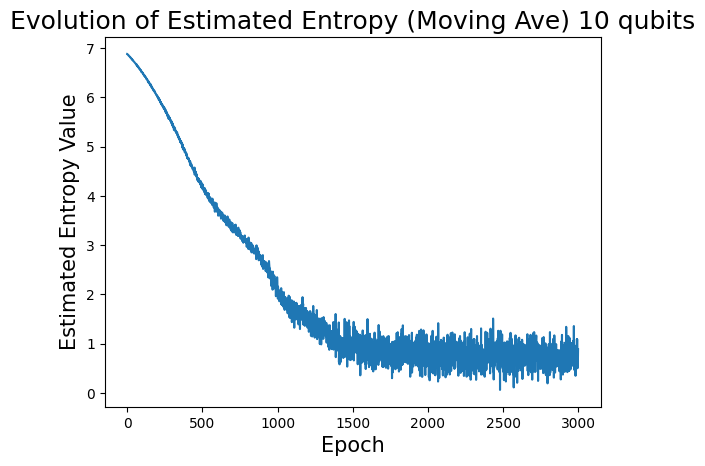

In [27]:
import matplotlib.pyplot as plt
plt.plot(cost_func_store)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Estimated Entropy Value', fontsize=15)
plt.title('Evolution of Estimated Entropy (Moving Ave) 10 qubits', fontsize=18)
plt.savefig(f"/home/mitsukism/qiskit_entropy/vn_net_cost/qubits10/cost_qubits{qubits}_seed{seed}.png")
plt.show()

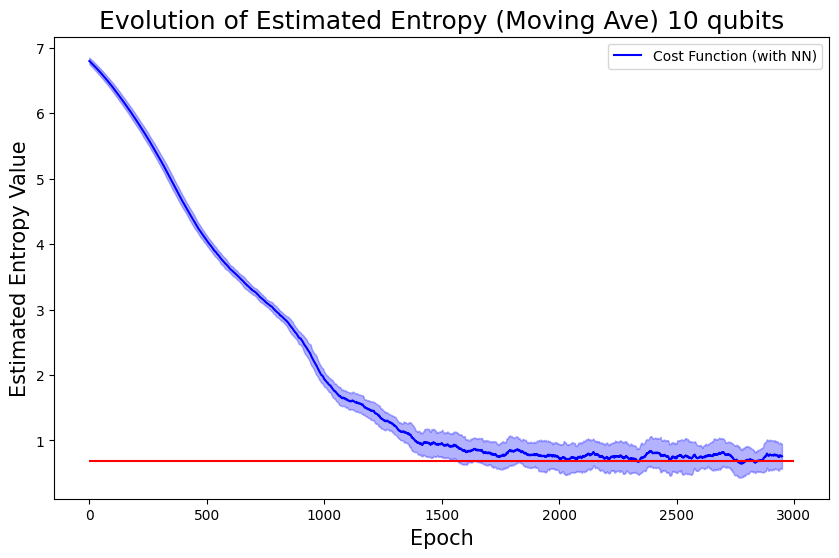

In [26]:
# 移動平均を計算する関数を定義
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 移動平均と標準偏差を計算
window_size = 50  # ウィンドウサイズを50とする
rolling_mean = moving_average(cost_func_store, window_size)
rolling_std = np.std([cost_func_store[i:i+window_size] for i in range(len(cost_func_store)-window_size+1)], axis=1)

# グラフの描画
plt.figure(figsize=(10, 6))

# 移動平均のプロット
plt.plot(rolling_mean, label='Cost Function (with NN)', color='blue', linewidth=1.5)

# 標準偏差を基に塗りつぶしを追加
plt.fill_between(range(len(rolling_mean)), rolling_mean - rolling_std, rolling_mean + rolling_std, color='blue', alpha=0.3)

# 軸ラベルとタイトルを追加
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Estimated Entropy Value', fontsize=15)
plt.title('Evolution of Estimated Entropy (Moving Ave) 10 qubits', fontsize=18)
plt.hlines(0.69, 0, 3000, color='red')

# 凡例の追加
plt.legend()

plt.savefig(f"/home/mitsukism/qiskit_entropy/vn_net_cost/qubits10/cost_qubits{qubits}_seed{seed}_process.png")

# グラフを表示
plt.show()